# Crypto Currency Analysis

## Bibliographic Notes

Crytocurrency markets are still a relatively new and relatively few academic papers are available that specifically address arbitrage on those markets. Early studies, such as the following, reported periods of large, recurrent arbitrage opportunities that exist across exchanges, and that can persist for several days or weeks.

> Makarov, I., & Schoar, A. (2020). Trading and arbitrage in cryptocurrency markets. Journal of Financial Economics, 135(2), 293-319.

Subsequent work reports these prices differentials do exist, but only at a fraction of the values previously reported, and only for fleeting periods of time. 

> Crépellière, T., & Zeisberger, S. (2020). Arbitrage in the Market for Cryptocurrencies. Available at SSRN 3606053.  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3606053

The use of network algorithms to identify cross-exchange arbitrage has appeared in the academic literature, and in numerous web sites demonstrating optimization and network applications. Representative examples are cited below.

> Peduzzi, G., James, J., & Xu, J. (2021, September). JACK THE RIPPLER: Arbitrage on the Decentralized Exchange of the XRP Ledger. In 2021 3rd Conference on Blockchain Research & Applications for Innovative Networks and Services (BRAINS) (pp. 1-2). IEEE. https://arxiv.org/pdf/2106.16158.pdf

> Bruzgė, R., & Šapkauskienė, A. (2022). Network analysis on Bitcoin arbitrage opportunities. The North American Journal of Economics and Finance, 59, 101562. https://doi.org/10.1016/j.najef.2021.101562

> Bruzgė, R., & Šapkauskienė, A. (2022). Dataset for Bitcoin arbitrage in different cryptocurrency exchanges. Data in Brief, 40, 107731. 

The work in this notebook is related to materials found in the following web resources.

> https://anilpai.medium.com/currency-arbitrage-using-bellman-ford-algorithm-8938dcea56ea

> [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)

A more complete analysis of trading and exploiting arbitrage opportunities in decentralized finance markets is available in the following paper and thesis.

> Byrne, S. An Exploration of Novel Trading and Arbitrage Methods within Decentralised Finance. https://www.scss.tcd.ie/Donal.OMahony/bfg/202021/StephenByrneDissertation.pdf

> Levus, R., Berko, A., Chyrun, L., Panasyuk, V., & Hrubel, M. (2021). Intelligent System for Arbitrage Situations Searching in the Cryptocurrency Market. In CEUR Workshop Proceedings (pp. 407-440). http://ceur-ws.org/Vol-2917/paper32.pdf

In addition to the analysis of arbitrage opportunities, convex optimization may also have an important role in the developing of trading algorithms for crypocurrency exchanges.

> Angeris, G., Agrawal, A., Evans, A., Chitra, T., & Boyd, S. (2021). Constant function market makers: Multi-asset trades via convex optimization. arXiv preprint arXiv:2107.12484. https://baincapitalcrypto.com/constant-function-market-makers-multi-asset-trades-via-convex-optimization/ and https://arxiv.org/pdf/2107.12484.pdf





## Installations and Imports

This notebook requires multiple libraries. The following cell performs the required installations for Google Colab. To operate your own device you will need to install the `pyomo`,`ccxt`, and `graphviz` python libraries, the graphviz executables, and a linear solver for Pyomo.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q ccxt
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

In [2]:
import os
from time import time
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import pyomo.environ as pyo
from graphviz import Digraph

## Accessing Exchange Trading Data

The open-source library `ccxt` currently supports APIs for 114 exchanges on which cryptocurrencies are traded.

In [3]:
import ccxt

print(ccxt.exchanges)

['aax', 'ascendex', 'bequant', 'bibox', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitopro', 'bitpanda', 'bitrue', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bkex', 'bl3p', 'blockchaincom', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'buda', 'bw', 'bybit', 'bytetrade', 'cdax', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinex', 'coinfalcon', 'coinmate', 'coinone', 'coinspot', 'crex24', 'cryptocom', 'currencycom', 'delta', 'deribit', 'digifinex', 'eqonex', 'exmo', 'flowbtc', 'fmfwio', 'ftx', 'ftxus', 'gateio', 'gemini', 'hitbtc', 'hitbtc3', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'itbit', 'kraken', 'kucoin', 'kucoinfutures', 'kuna', 'latoken', 'lbank', 'liquid', 'luno', 'lykke', 'mercado', 'mexc', 'ndax', 'novadax', 'oceanex',

### Select an exchange and load available symbols

Each of the exchanges supported by `ccxt` offers multiple **markets**, each market defined by two (possibly more) currencies. `ccxt` labels each market with an id and with a symbol. The market id is unique per exchange and are there for HTTP request-response purposes. The symbol, however, are common across exchanges which make them suitable for arbitrage and other cross-exchange analyses.

Each symbol is usually an upper case string with names for a pair of traded currencies separated by a slash. The first is called the base currency, and the second the quote currency. Here we refer to the base currency as the source SRC, and the quote currency as the destination DST.

$$SRC/DST$$

Associated with each symbol are two potential market transactions.

* $SRC \rightarrow DST$ converts one unit of the currency desigated by $SRC$ on the exchange to multiple units of the currency designated $DST$ at the 'bid' price.
* $DST \rightarrow SRC$ converts one unit of $DST$ on to multiple units of $SRC$ at the inverse of the 'ask' price.

Here we represent the transcations using nodes and edges from graph theory. Each node is designates a currency trading on the exchange. Each edge corresponds to a currency transaction comprised of a source and destination node. Here we assume all currencies are being traded on the same exchange. This notation can be extended to multi-exchange trading by designating nodes as (exchange, currency) pairs.



In [43]:
import ccxt
import networkx as nx
import pandas as pd

# global variables used in subsequent cells
exchange = ccxt.binanceus()
markets = exchange.load_markets()
symbols = exchange.symbols

# split symbols into a list of SRC -> DST pairs
src_dst_pairs = [symbol.split("/") for symbol in symbols]

# sorted list of all unique currencies
currencies = [currency for src_dst in src_dst_pairs for currency in src_dst]
currencies = sorted(list(set(currencies)))

# sources and destinations dictionaries for currency in currencies
sources = dict()
for currency in currencies:
    sources[currency] = [src for src, dst in src_dst_pairs if dst == currency]

destinations = dict()
for currency in currencies:
    destinations[currency] = [dst for src, dst in src_dst_pairs if src == currency]

We seek ways of restricting the graph to the most traded or most liquid currencies. Here we identify the "base" currencies as those appearing in the destination list, and keep source currencies that are traded in $N$ or more base currencies.

Number of nodes =  15
Number of edges =  50


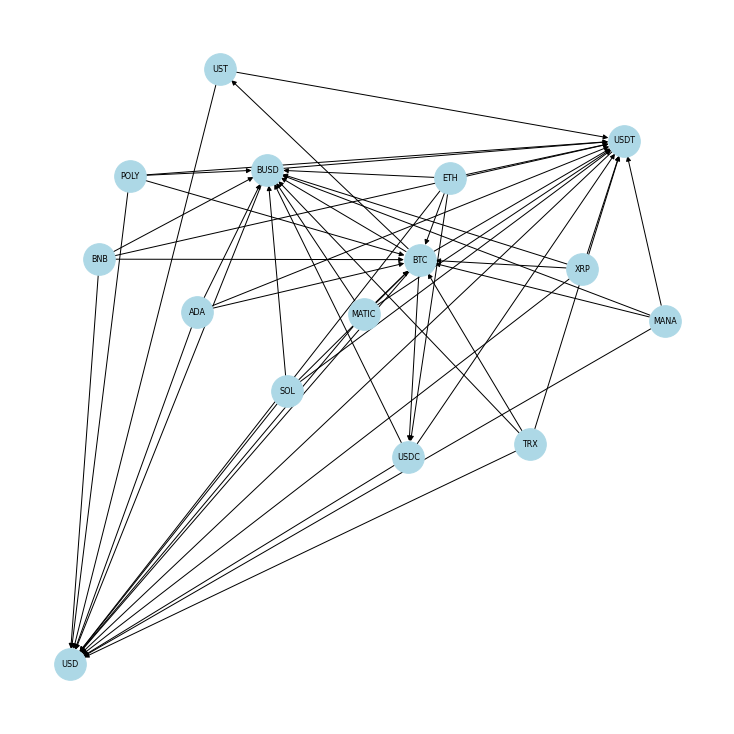

In [63]:
import matplotlib.pyplot as plt
import networkx as nx

# list of currencies traded in N or more quote currencies
N = 4
nodes = [
    currency
    for currency in currencies
    if ((len(sources[currency]) >= 1) or (len(destinations[currency]) >= N))
]

dg = nx.DiGraph()
for currency in nodes:
    dg.add_node(currency)
    for src in sources[currency]:
        if src in select:
            dg.add_edge(src, currency)
    for dst in destinations[currency]:
        if dst in select:
            dg.add_edge(currency, dst)
            
edges = dg.edges()
print(f"Number of nodes = {len(nodes):3d}")
print(f"Number of edges = {len(edges):3d}")

fig = plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, iterations=100)
nx.draw(
    dg,
    with_labels=True,
    node_color="lightblue",
    node_size=1000,
    font_size=8,
    arrowsize=10,
)

## Order Book

In [61]:
trade_symbols = ["/".join(edge) for edge in edges]


def fetch_order_book(symbol, limit=1, exchange=exchange):
    """return order book data for a specified symbol"""
    start_time = timer()
    result = exchange.fetch_order_book(symbol, limit)
    result["src"], result["dst"] = symbol.split("/")
    result["run_time"] = timer() - start_time
    result["timestamp"] = exchange.milliseconds()
    if result["bids"]:
        result["bid_price"] = result["bids"][0][0]
        result["bid_volume"] = result["bids"][0][1]
    if result["asks"]:
        result["ask_price"] = result["asks"][0][0]
        result["ask_volume"] = result["asks"][0][1]
    return result


# fetch order book data and store in a dictionay
start = timer()
fetched_order_book = {symbol: fetch_order_book(symbol) for symbol in trade_symbols}
run_time = timer() - start
print(
    f"fetched order book for {len(fetched_order_book)} symbols in {run_time:0.3f} seconds"
)

# convert to pandas dataframe
order_book = pd.DataFrame(fetched_order_book).T
order_book.drop(columns=["datetime", "symbol", "bids", "asks"], inplace=True)
order_book["timestamp"] = pd.to_datetime(order_book["timestamp"], unit="ms")
order_book

fetched order book for 50 symbols in 3.077 seconds


,timestamp,nonce,src,dst,run_time,bid_price,bid_volume,ask_price,ask_volume
ADA/BTC,2022-04-29 10:41:05.099,113567820,ADA,BTC,0.25193,0.000021,1605.0,0.000021,2242.0
ADA/BUSD,2022-04-29 10:41:05.205,5487394,ADA,BUSD,0.106449,0.817,1392.2,0.819,2459.9
ADA/USD,2022-04-29 10:41:05.261,928117196,ADA,USD,0.056402,0.8176,2521.5,0.8181,1222.1
ADA/USDT,2022-04-29 10:41:05.316,541857546,ADA,USDT,0.054412,0.81776,440.0,0.8183,440.0
BTC/BUSD,2022-04-29 10:41:05.371,465914618,BTC,BUSD,0.055005,39069.79,0.043,39104.12,0.000256
BTC/USD,2022-04-29 10:41:05.426,1895680323,BTC,USD,0.055289,39097.41,0.001576,39100.85,0.165
BTC/USDC,2022-04-29 10:41:05.481,192295456,BTC,USDC,0.054648,39090.33,0.05,39105.21,0.05
BTC/USDT,2022-04-29 10:41:05.536,990373932,BTC,USDT,0.054882,39092.52,0.04,39103.95,0.065
BTC/UST,2022-04-29 10:41:05.599,466589,BTC,UST,0.063453,39060.4,0.03187,39137.39,0.038
BUSD/USD,2022-04-29 10:41:05.657,9614682,BUSD,USD,0.057422,0.9999,1391893.51,1.0,352005.05


## Create directed graph of the order book

In [64]:
# dictionary of edges indexed by (src, dst) tuples
#     type: 'bid' or 'ask'
#     conv: 1 unit of src currency produces conv units of dst currency
#     log10_conv: log10 of conv
bids = {
    (order_book.at[symbol, "src"], order_book.at[symbol, "dst"]): {
        "type": "bid",
        "conv": order_book.at[symbol, "bid_price"],
        "log10_conv": np.log10(order_book.at[symbol, "bid_price"]),
        #'volume': order_book.at[symbol, 'bid_volume'],
    }
    for symbol in order_book.index
    if not np.isnan(order_book.at[symbol, "bid_volume"])
}

asks = {
    (order_book.at[symbol, "dst"], order_book.at[symbol, "src"]): {
        "type": "ask",
        "conv": 1.0 / order_book.at[symbol, "ask_price"],
        "log10_conv": np.log10(1.0 / order_book.at[symbol, "ask_price"]),
        #'volume': 1.0/order_book.at[symbol, 'ask_volume'],
    }
    for symbol in order_book.index
    if not np.isnan(order_book.at[symbol, "ask_volume"])
}

In [67]:
edges = dict()
edges.update(bids)
edges.update(asks)
print(len(edges))

92


## Graphviz

https://graphviz.readthedocs.io/en/stable/


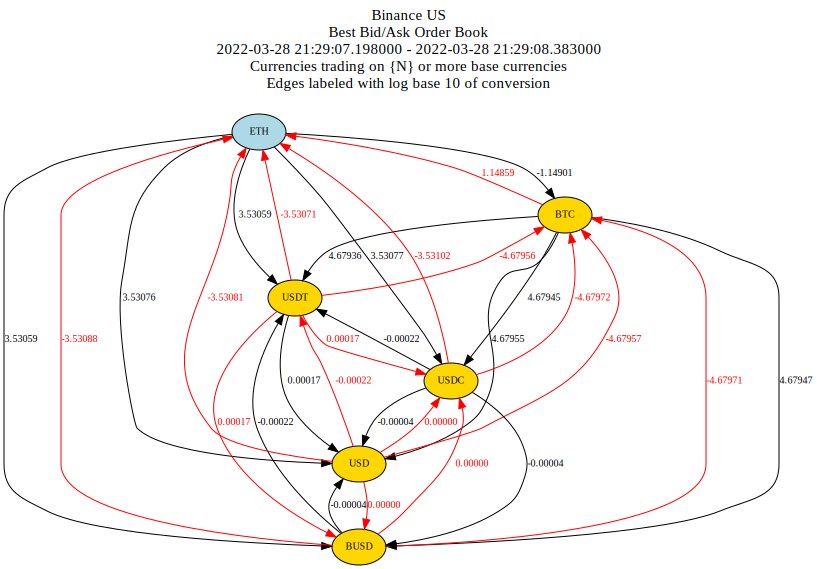

'exchange-dag.png'

In [10]:
# plot a directed graph from the edges and nodes

timestamp_min = order_book["timestamp"].min()
timestamp_max = order_book["timestamp"].max()

label = (
    f"{exchange} \nBest Bid/Ask Order Book\n{timestamp_min} - {timestamp_max}"
    + "\nCurrencies trading on {N} or more base currencies"
    + "\nEdges labeled with log base 10 of conversion"
    + "\n "
)
dot = Digraph(
    graph_attr={"label": label, "fontsize": "15", "labelloc": "t"},
    node_attr={"fontsize": "10"},
    edge_attr={"fontsize": "10"},
)

for node, prop in nodes.items():
    if prop["type"] == "dst":
        dot.node(node, style="filled", fillcolor="gold")
    else:
        dot.node(node, style="filled", fillcolor="lightblue")

for edge, prop in edges.items():
    src, dst = edge
    log10_conv = prop["log10_conv"]
    label = f"{log10_conv:0.5f}"
    if prop["type"] == "bid":
        dot.edge(src, dst, label, color="black", fontcolor="black")
    else:
        dot.edge(src, dst, label, color="red", fontcolor="red")

display(dot)
dot.format = "png"
dot.view("exchange-dag")

In [11]:
# split the graph on USD ...

nodes["USD-SRC"] = {"type": "src"}
nodes["USD-DST"] = {"type": "dst"}
nodes.pop("USD", None)

for edge in list(edges.keys()):
    src, dst = edge
    if src == "USD":
        value = edges[edge]
        edges[("USD-SRC", dst)] = value

    elif dst == "USD":
        value = edges[edge]
        edges[(src, "USD-DST")] = value

for edge in list(edges.keys()):
    src, dst = edge
    if (src == "USD") or (dst == "USD"):
        edges.pop(edge)

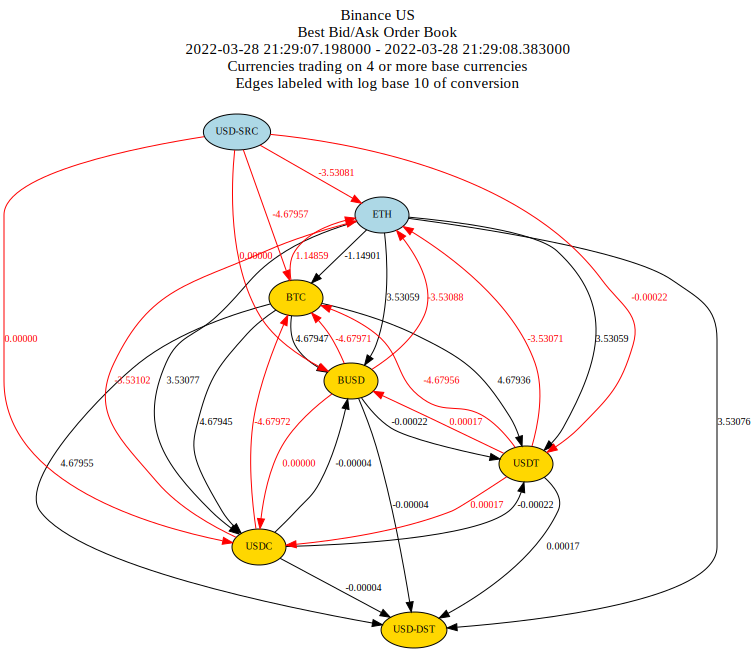

'exchange-dag.png'

In [12]:
label = (
    f"{exchange} \nBest Bid/Ask Order Book\n{timestamp_min} - {timestamp_max}"
    + f"\nCurrencies trading on {N} or more base currencies"
    + "\nEdges labeled with log base 10 of conversion"
    + "\n "
)
dot = Digraph(
    graph_attr={"label": label, "fontsize": "15", "labelloc": "t"},
    node_attr={"fontsize": "10"},
    edge_attr={"fontsize": "10"},
)

for node, prop in nodes.items():
    if prop["type"] == "dst":
        dot.node(node, style="filled", fillcolor="gold")
    else:
        dot.node(node, style="filled", fillcolor="lightblue")

for edge, prop in edges.items():
    src, dst = edge
    log10_conv = prop["log10_conv"]
    label = f"{log10_conv:0.5f}"
    if prop["type"] == "bid":
        dot.edge(src, dst, label, color="black", fontcolor="black")
    else:
        dot.edge(src, dst, label, color="red", fontcolor="red")

display(dot)
dot.format = "png"
dot.view("exchange-dag")

In [13]:
import pyomo.environ as pyo

T = 10

m = pyo.ConcreteModel(f"{exchange} arbitrage")

# length of the trading chain
m.T0 = pyo.RangeSet(0, T)
m.T1 = pyo.RangeSet(1, T)

# currency nodes and trading edges
m.NODES = pyo.Set(initialize=nodes.keys())
m.EDGES = pyo.Set(initialize=edges.keys())

# "gain" on each trading edge
@m.Param(m.EDGES)
def a(m, src, dst):
    return 10 ** edges[(src, dst)]["log10_conv"]


# currency on hand at each node
m.w = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

# amount traded on each edge
m.x = pyo.Var(m.EDGES, m.T1, domain=pyo.NonNegativeReals)


@m.Objective(sense=pyo.maximize)
def wealth(m):
    return m.w["USD-DST", T]


# initial assignment of 100 units on a selected currency
@m.Constraint(m.NODES)
def initial(m, node):
    if node == "USD-SRC":
        return m.w[node, 0] == 1.0
    return m.w[node, 0] == 0.0


@m.Constraint(m.NODES, m.T1)
def no_shorting(m, node, t):
    return m.w[node, t - 1] >= sum(
        m.x[node, dst, t] for src, dst in m.EDGES if src == node
    )


@m.Constraint(m.NODES, m.T1)
def balances(m, node, t):
    return m.w[node, t] == m.w[node, t - 1] - sum(
        m.x[node, dst, t] for src, dst in m.EDGES if src == node
    ) + sum(m.a[src, node] * m.x[src, node, t] for src, dst in m.EDGES if dst == node)


solver = pyo.SolverFactory("cbc")
solver.solve(m)

for node in m.NODES:
    print(f"{node:8s}", end="")
    for t in m.T0:
        print(f" {m.w[node, t]():12.8f}", end="")
    print()

print()

for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 0:
            print(f"{src:8s} -> {dst:8s}: {m.x[src, dst, t]():0.8f}")
    print()

ETH        0.00000000   0.00000000   0.00000000   0.00000000  -0.00000000   0.00000000   0.00000000  -0.00000000   0.00000000   0.00000000   0.00000000
BTC        0.00000000   0.00000000   0.00000000   0.00002091   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
BUSD       0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
USDC       0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
USDT       0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
USD-SRC    1.00000000   1.00000000   1.00000000  -0.00000000  -0.00000000  -0.00000000  -0.00000000  -0.00000000  -0.00000000  -0.00000000   0.00000000
USD-DST    0.00000000   0.00000000   0.00000000   0.00000000   0.99994981   0.99994981  

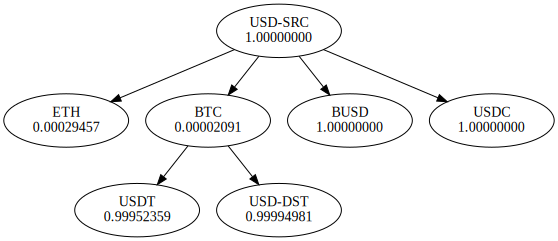

In [14]:
import math

n = len(nodes)


def visualize(bf):
    adot = Digraph()
    for node in bf.keys():
        w = 10 ** (-bf[node]["w"])
        if math.isinf(w):
            adot.node(node)
        else:
            adot.node(node, label=f"{node}\n{w:0.8f}")
        if bf[node]["prec"] is not None:
            adot.edge(bf[node]["prec"], node)
    display(adot)


# dictionary of all nodes.
#   prec: preceding node
#   w: weight

bf = {node: {"prec": None, "w": float("inf")} for node in nodes}
bf["USD-SRC"]["w"] = 0

for _ in range(n - 1):
    for edge in edges.keys():
        src, dst = edge
        w = -edges[edge]["log10_conv"]
        if bf[dst]["w"] > (bf[src]["w"] + w):
            bf[dst]["w"] = bf[src]["w"] + w
            bf[dst]["prec"] = src

visualize(bf)

## Appendix: Asynchronous downloads of order book data

Considerably more development, testing, and validation would be needed to adapt this code to an automated tradign bot to exploit arbitrage opportunities in the crypto-currency markets. One of the time consuming steps is accessing order book data. The following cell is an experiment using the Python `asyncio` library to determine if asynchronous calls to the `ccxt` would provide faster downloads. 

Preliminary testing shows little or no advantage to `asyncio` when working with a single exchange. That may change when the above code is adapted to multi-exchange arbitrage, and therefore this code is retained below for future testing.

In [15]:
%%script echo skipping

from timeit import default_timer as timer

# asynchronous implementation
import asyncio
import nest_asyncio

my_symbols = ['/'.join(edge) for edge in edges]

async def afetch_order_book(symbol, limit=1, exchange=exchange):
    start_time = timer()
    result = exchange.fetch_order_book(symbol, limit)
    run_time = timer() - start_time
    return result

async def get_data():
    coroutines = [afetch_order_book(symbol) for symbol in my_symbols]
    await asyncio.gather(*coroutines)

start = timer()
nest_asyncio.apply()
asyncio.run(get_data())
run_time = timer() - start

print(run_time)

skipping


In [7]:
# trim currencies to those that appears as DST, or are N or more SRC

# all currencies trading in N or more base currencies
N = 4

src_nodes = list(src_count[src_count > N].index)
dst_nodes = list(dst_count[dst_count > 1].index)
src_dst_nodes = list(set(src_nodes + dst_nodes))

# plot a directed graph from the edges and nodes
label = f"{exchange}\ntrading symbols with {N} or more base currencies\n "
dg = Digraph(
    f"{exchange}",
    graph_attr={"label": label, "fontsize": "15", "labelloc": "t"},
    node_attr={"fontsize": "12"},
    edge_attr={"fontsize": "10"},
)

for node in src_nodes:
    label = f"{node}"
    dg.node(node, label, style="filled", fillcolor="lightblue")

for node in dst_nodes:
    label = f"{node}"
    dg.node(node, label, style="filled", fillcolor="gold")

trade_edges = [
    [src, dst]
    for src, dst in src_dst_pairs
    if (src in src_dst_nodes) and (dst in src_dst_nodes)
]
for src, dst in trade_edges:
    symbol = "/".join([src, dst])
    label = f"{symbol}"
    dg.edge(src, dst, label)

display(dg)
dg.format = "png"
dg.view("exchange-symbol-map")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH